In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.filterwarnings("ignore") 

import os
import shutil

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from torchvision.models import resnet18, vgg16
from torchvision.transforms import transforms
from torch.nn import Linear, CrossEntropyLoss
import optuna
from tqdm import tqdm

In [4]:
train_path = '/kaggle/input/miniimagenet/train/'
output_path = '/kaggle/working/miniimagenet/'

categories = os.listdir(train_path)
len(categories)

64

In [5]:
for category in categories:
    category_path = os.path.join(train_path, category)
    images = os.listdir(category_path)

    train, rest = train_test_split(images, test_size=0.2, random_state=0)
    val, test = train_test_split(rest, test_size=0.5, random_state=0)

    os.makedirs(os.path.join(output_path, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', category), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'test', category), exist_ok=True)

    for img in train:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'train', category, img))
    for img in val:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'val', category, img))
    for img in test:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_path, 'test', category, img))

In [6]:
from transformers import ViTModel, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", do_rescale=False)
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [8]:
from torchvision.datasets import ImageFolder

BATCH_SIZE = 32 
NUM_EPOCHS = 5

train_path = '/kaggle/working/miniimagenet/train/'
val_path = '/kaggle/working/miniimagenet/val/'
test_path = '/kaggle/working/miniimagenet/test/'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
NUM_CLASSES = len(train_dataset.classes)
classification_head = Linear(model.config.hidden_size, NUM_CLASSES).to(device)

In [10]:
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [11]:
def train_model(model, classification_head, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS, early_stopping_patience=3):
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    classification_head.to(device)

    loss_fn = CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

    for epoch in range(num_epochs):
        # Training Step
        model.train()
        classification_head.train()
        
        total_loss = 0
        correct_train_predictions = 0
        total_train_samples = 0
        
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for images, labels in train_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            inputs = image_processor(images, return_tensors="pt").to(device)
            outputs = model(**inputs).last_hidden_state
            outputs = outputs[:, 0, :]
            logits = classification_head(outputs)

            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            _, predictions = torch.max(logits, 1)
            correct_train_predictions += (predictions == labels).sum().item()
            total_train_samples += labels.size(0)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Step
        model.eval()
        classification_head.eval()
        
        total_val_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images = images.to(device)
                labels = labels.to(device)

                inputs = image_processor(images, return_tensors="pt").to(device)
                outputs = model(**inputs).last_hidden_state
                outputs = outputs[:, 0, :]
                logits = classification_head(outputs)

                val_loss = loss_fn(logits, labels)
                total_val_loss += val_loss.item()

                _, predictions = torch.max(logits, 1)
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                
                val_progress_bar.set_postfix(loss=val_loss.item())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_predictions / total_samples
        
        scheduler.step(avg_val_loss)
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement in validation loss.")
            break
        
    return train_losses, train_accuracies, val_losses, val_accuracies

In [12]:
def test_model(model, classification_head, test_loader):
    if torch.cuda.device_count() > 1:
        print(f"{torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model.eval()
    classification_head.eval()

    total_test_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    test_losses = []
    test_accuracies = []

    loss_fn = CrossEntropyLoss()

    test_progress_bar = tqdm(test_loader, desc='Testing')

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            inputs = image_processor(images, return_tensors="pt").to(device)
            outputs = model(**inputs).last_hidden_state
            outputs = outputs[:, 0, :]
            logits = classification_head(outputs)

            test_loss = loss_fn(logits, labels)
            total_test_loss += test_loss.item()

            _, predictions = torch.max(logits, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            test_progress_bar.set_postfix(loss=test_loss.item())
            
            test_losses.append(test_loss.item())
            test_accuracies.append((predictions == labels).sum().item() / labels.size(0))

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_losses, test_accuracies

In [13]:
# def objective(trial):
#     model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#     classification_head = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    
#     model.to(device)
#     classification_head.to(device)
    
#     # Get optimizer name from trial
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", 'RMSprop', 'AdamW'])
    
#     # Get other hyperparameters
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    
#     # Dynamically get the optimizer class using getattr
#     optimizer_cls = getattr(optim, optimizer_name)
    
#     # Initialize optimizer with suggested learning rate
#     optimizer = optimizer_cls(
#         list(model.parameters()) + list(classification_head.parameters()),
#         lr=lr,
#     )
    
#     # Train and validate the model with the classification head
#     val_loss = train_model(
#         model, classification_head, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS
#     )
    
#     # Return the negative validation loss as Optuna minimizes the objective
#     return -val_loss

In [14]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

In [15]:
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

### with RMSprop

In [16]:
NUM_CLASSES = len(train_dataset.classes)
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

optimizer = optim.RMSprop(list(model.parameters()) + list(classification_head.parameters()), lr=LEARNING_RATE)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, classification_head, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS
    )

2 GPUs!


Epoch 1/10 [Validation]: 100%|██████████| 120/120 [01:09<00:00,  1.74it/s, loss=2.84]


Epoch 1/10, Training loss: 3.2259, Training Accuracy: 0.7850, Validation loss: 2.4652, Validation Accuracy: 0.9060


Epoch 2/10 [Validation]: 100%|██████████| 120/120 [01:07<00:00,  1.78it/s, loss=1.69]


Epoch 2/10, Training loss: 1.8373, Training Accuracy: 0.9292, Validation loss: 1.3843, Validation Accuracy: 0.9263


Epoch 3/10 [Validation]: 100%|██████████| 120/120 [01:08<00:00,  1.75it/s, loss=1.07]


Epoch 3/10, Training loss: 0.9304, Training Accuracy: 0.9588, Validation loss: 0.7549, Validation Accuracy: 0.9354


Epoch 4/10 [Validation]: 100%|██████████| 120/120 [01:07<00:00,  1.77it/s, loss=0.949]


Epoch 4/10, Training loss: 0.4250, Training Accuracy: 0.9765, Validation loss: 0.4548, Validation Accuracy: 0.9375


Epoch 5/10 [Validation]: 100%|██████████| 120/120 [01:08<00:00,  1.75it/s, loss=0.745]


Epoch 5/10, Training loss: 0.1888, Training Accuracy: 0.9867, Validation loss: 0.3387, Validation Accuracy: 0.9354


Epoch 6/10 [Validation]: 100%|██████████| 120/120 [01:08<00:00,  1.76it/s, loss=0.798]


Epoch 6/10, Training loss: 0.0862, Training Accuracy: 0.9930, Validation loss: 0.3093, Validation Accuracy: 0.9339


Epoch 7/10 [Validation]: 100%|██████████| 120/120 [01:08<00:00,  1.75it/s, loss=0.607]


Epoch 7/10, Training loss: 0.0408, Training Accuracy: 0.9968, Validation loss: 0.3061, Validation Accuracy: 0.9354


Epoch 8/10 [Validation]: 100%|██████████| 120/120 [01:07<00:00,  1.77it/s, loss=0.564]


Epoch 8/10, Training loss: 0.0218, Training Accuracy: 0.9979, Validation loss: 0.2940, Validation Accuracy: 0.9398


Epoch 9/10 [Validation]: 100%|██████████| 120/120 [01:07<00:00,  1.78it/s, loss=0.531]


Epoch 9/10, Training loss: 0.0128, Training Accuracy: 0.9987, Validation loss: 0.3316, Validation Accuracy: 0.9385


Epoch 10/10 [Validation]: 100%|██████████| 120/120 [01:07<00:00,  1.77it/s, loss=0.838]

Epoch 10/10, Training loss: 0.0082, Training Accuracy: 0.9989, Validation loss: 0.3482, Validation Accuracy: 0.9380


In [17]:
torch.save(model.state_dict(), 'vit_model_rmsprop.pth')

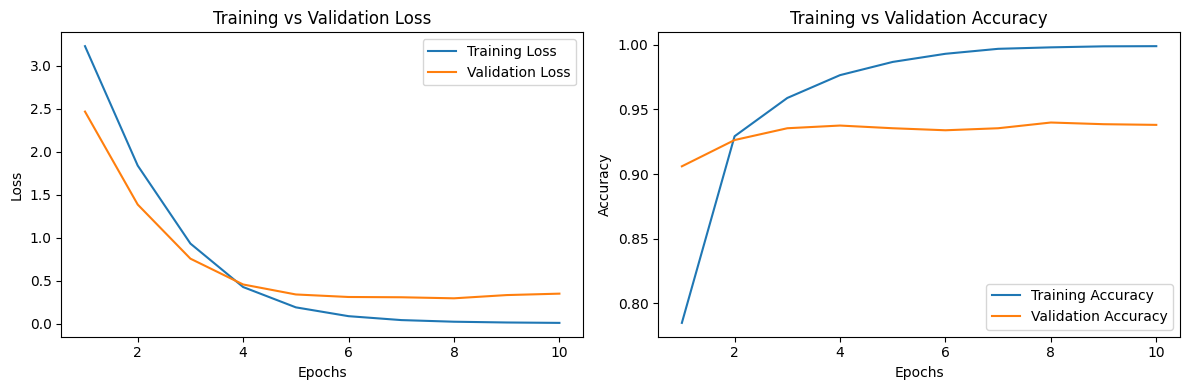

In [18]:
epochs = range(1, len(train_losses) + 1)

# Training vs Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Evaluate the model
model_path = '/kaggle/working/vit_model_rmsprop.pth'
model.load_state_dict(torch.load(model_path))
test_losses, test_accuracies = test_model(model, classification_head, test_loader)

2 GPUs!


Testing: 100%|██████████| 120/120 [01:07<00:00,  1.78it/s, loss=0.00288]

Test Loss: 0.3811, Test Accuracy: 0.9315


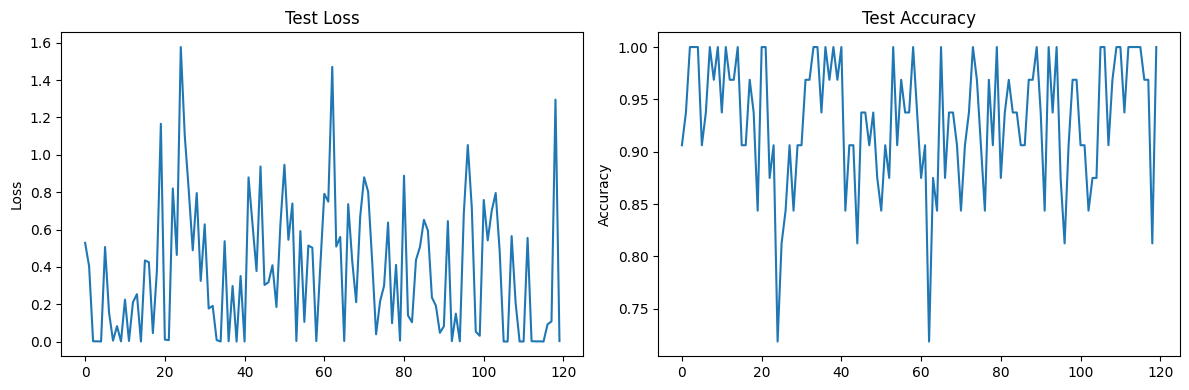

In [20]:

# epochs = range(1, len(test_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.ylabel('Loss')
plt.title('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

In [21]:
torch.cuda.empty_cache()

### with AdamW

In [22]:
# NUM_CLASSES = len(train_dataset.classes)
# NUM_EPOCHS = 10
# LEARNING_RATE = 0.0001

# optimizer = optim.AdamW(list(model.parameters()) + list(classification_head.parameters()), lr=LEARNING_RATE)

# train_losses, train_accuracies, val_losses, val_accuracies = train_model(
#         model, classification_head, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS
#     )

In [23]:
# torch.save(model.state_dict(), 'vit_model_adamw.pth')

In [24]:
# epochs = range(1, len(train_losses) + 1)

# # Training vs Validation Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, label='Training Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()

# # Training vs Validation Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training vs Validation Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [25]:
# # Evaluate the model
# model_path = '/kaggle/working/vit_model_adamw.pth'
# model.load_state_dict(torch.load(model_path))
# test_losses, test_accuracies = test_model(model, classification_head, test_loader)

In [26]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(test_losses, label='Test Loss')
# plt.ylabel('Loss')
# plt.title('Test Loss')

# plt.subplot(1, 2, 2)
# plt.plot(test_accuracies, label='Test Accuracy')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')

# plt.tight_layout()
# plt.show()